In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
import os
import random
import numpy.matlib
from time import process_time
import scipy
import matplotlib.pyplot as plt
import PIL
# why is this here? This is disabling some tensorflow warning I get in some of my environments that
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras import layers
from keras.models import Sequential
import pathlib
import cv2   

import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from keras import activations
from keras.regularizers import l2

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

In [2]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data loading

In [3]:
#Setting directory
data_dir_train = pathlib.Path("./split/train/").with_suffix('')
data_dir_val = pathlib.Path("./split/val/").with_suffix('')
data_dir_test = pathlib.Path("./split/test/").with_suffix('')

#Setting batch size and heoght and width of images
batch_size = None
img_height = 72
img_width = 128


#creating a training dataset with 60% split. 
train_ds = keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0,
  #subset="training",
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Splitting X and Y and converting them into numpy array
train_Y = np.array([y.numpy() for x, y in train_ds])
train_X = np.array([x.numpy() for x, y in train_ds])

print(train_X.shape)
print(train_Y.shape)
    

Found 7088 files belonging to 7 classes.
(7088, 72, 128, 3)
(7088,)


In [4]:
# train_Y = np.argmax(train_Y, axis=1)
print(train_Y)  

[0 0 6 ... 0 6 2]


In [5]:
print(np.unique(train_Y))

[0 1 2 3 4 5 6]


In [6]:
#creating a training dataset with 60% split. 
val_ds = keras.utils.image_dataset_from_directory(
  data_dir_val,
  validation_split=0,
  #subset="training",
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Splitting X and Y and converting them into numpy array
val_Y = np.array([y.numpy() for x, y in val_ds])
val_X = np.array([x.numpy() for x, y in val_ds])

print(val_X.shape)
print(val_Y.shape)

Found 1515 files belonging to 7 classes.
(1515, 72, 128, 3)
(1515,)


In [7]:
#creating a training dataset with 60% split. 
test_ds = keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0,
  #subset="training",
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Splitting X and Y and converting them into numpy array
test_Y = np.array([y.numpy() for x, y in test_ds])
test_X = np.array([x.numpy() for x, y in test_ds])
    

print(test_X.shape)
print(test_Y.shape)

Found 1527 files belonging to 7 classes.
(1527, 72, 128, 3)
(1527,)


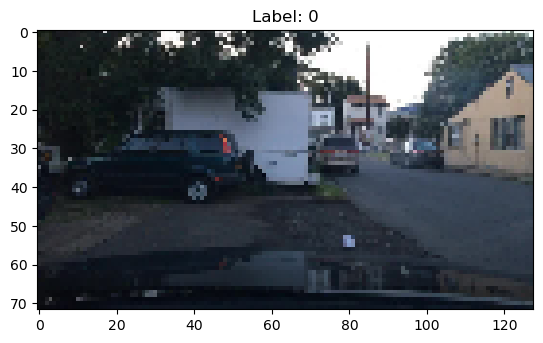

In [8]:
# Let's print the first image in train set
first_image = train_X[0]/ 255.0
first_label = train_Y[0]

plt.imshow(first_image)
plt.title(f'Label: {first_label}')
plt.show()


In [9]:
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:] / 255.0, cmap=plt.get_cmap('gray')) #cv2.cvtColor(cv2.imread(x[0][i,:]), cv2.COLOR_BGR2RGB) / 255.0
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:] / 255.0, cmap=plt.get_cmap('gray'))    
        ax.set_title('Triple ' + str(i) + ': Positive')#cv2.cvtColor(cv2.imread(x[1][i,:]), cv2.COLOR_BGR2RGB) / 255.0

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:] / 255.0, cmap=plt.get_cmap('gray'))   #cv2.cvtColor(cv2.imread(x[2][i,:]), cv2.COLOR_BGR2RGB) / 255.0 
        ax.set_title('Triple ' + str(i) + ': Negative')

        

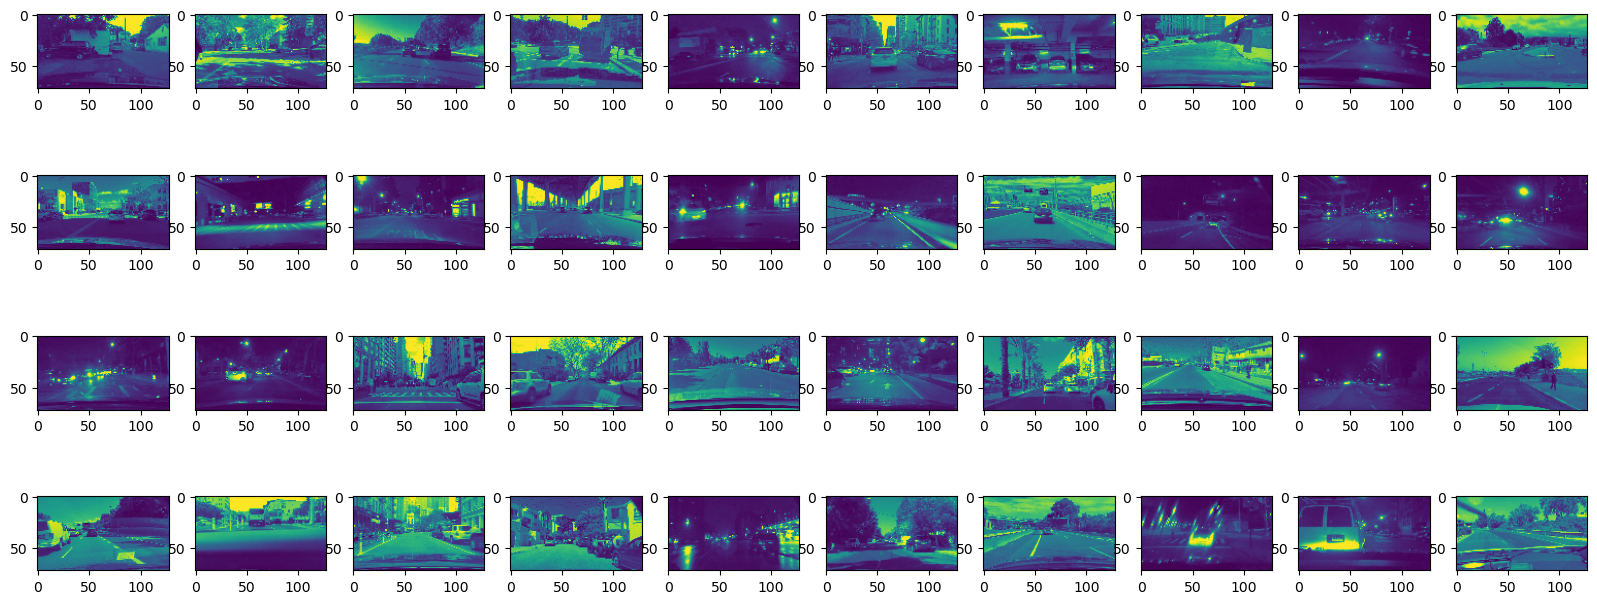

In [10]:
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_X[i,:,:,0])

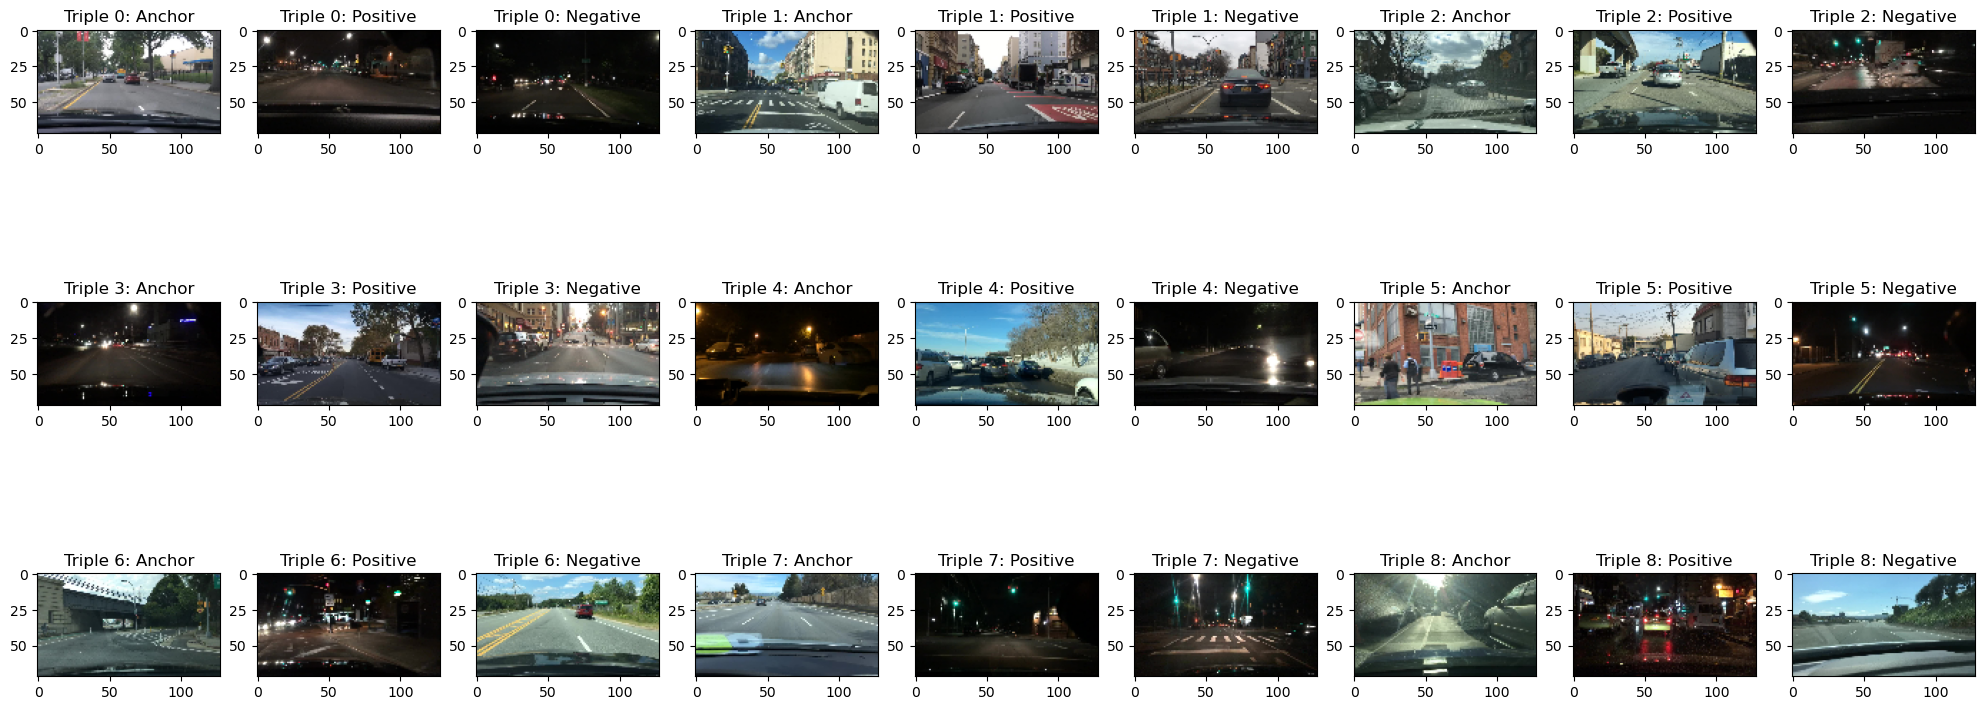

In [11]:
# create a triplet and display a triplet
x = get_triplet_data(train_X,train_Y , 9)
plot_triplets(x)

In [12]:
def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)


class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    


In [13]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(inputs, filters, num_res_blocks, pool_size):

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y

In [14]:
inputs = keras.layers.Input(shape=(72, 128, 3, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 7)#inputs, filters, num_res_blocks, pool_size
output = keras.layers.Dense(64)(x)

backbone = keras.Model(inputs = inputs, outputs = output)
backbone.summary()
backbone.compile(jit_compile = False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 72, 128,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 72, 128,   │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 72, 128,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 72, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 128,   │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 128,   │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128,   │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 128,   │          0 │ activation[0][0], │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 128,   │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 72, 128,   │      2,320 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128,   │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 72, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 128,   │      2,320 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128,   │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 128,   │          0 │ activation_2[0][

 Total params: 208,736 (815.38 KB)

 Trainable params: 207,808 (811.75 KB)

 Non-trainable params: 928 (3.62 KB)

In [15]:
# data_augmentation = keras.Sequential([
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.02),
#   layers.RandomZoom(0.025),
#   layers.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
# ])

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomContrast(0.8)
    ],
    name="data_augmentation",
)

In [16]:
inputs_a = keras.layers.Input(shape=(72, 128, 3, ), name='img_a')
inputs_p = keras.layers.Input(shape=(72, 128, 3, ), name='img_p')
inputs_n = keras.layers.Input(shape=(72, 128, 3, ), name='img_n')

In [17]:
augmented_a = data_augmentation(inputs_a)
augmented_p = data_augmentation(inputs_p)
augmented_n = data_augmentation(inputs_n)

In [18]:
embedding_a = backbone(augmented_a)
embedding_p = backbone(augmented_p)
embedding_n = backbone(augmented_n)

# embedding_a = backbone(inputs_a)
# embedding_p = backbone(inputs_p)
# embedding_n = backbone(inputs_n)

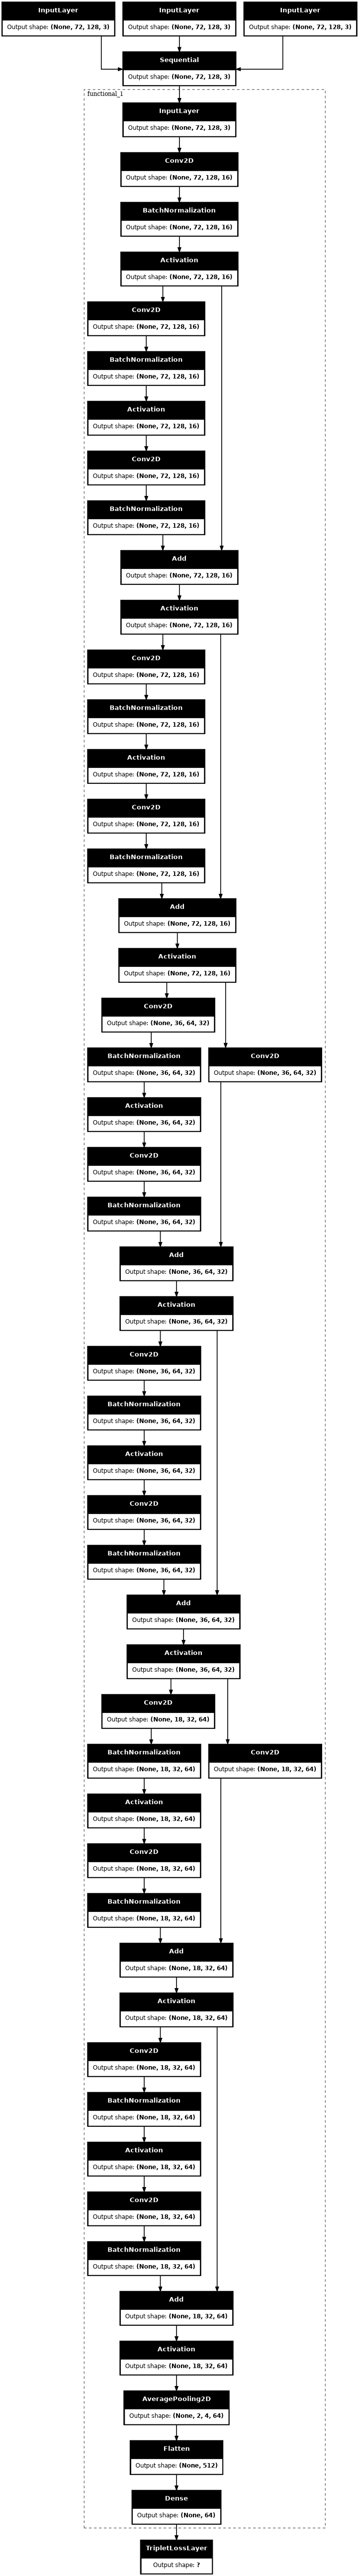

In [19]:
margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')(
    [embedding_a, embedding_p, embedding_n])

triplet_network = keras.Model([inputs_a, inputs_p, inputs_n], loss_layer)
keras.utils.plot_model(triplet_network, show_shapes=True, dpi = 60, expand_nested=True)

In [20]:
# note I'm selecting no metrics here, accuracy doesn't make sense for the way that we're training the model
triplet_network.compile(optimizer=keras.optimizers.AdamW(), metrics=[], jit_compile=False)

In [21]:
triplet_test_x = get_triplet_data(test_X, test_Y, 500)

In [22]:
Triplet_train_start = process_time()
for i in range(50):
    triplet_train_x = get_triplet_data(train_X,train_Y, 2000)
    triplet_network.fit(triplet_train_x, y=None, batch_size = 32, epochs=1, 
                        validation_data = (triplet_test_x, None))
Triplet_train_end = process_time()
Triplet_train_time = Triplet_train_end - Triplet_train_start
print("Triplet_train_time: ", Triplet_train_time)

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 561ms/step - loss: 32.2333 - val_loss: 30.6342
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - loss: 32.0648 - val_loss: 31.1896
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - loss: 32.0382 - val_loss: 31.7115
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - loss: 31.7476 - val_loss: 31.2754
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 31.7834 - val_loss: 31.8382
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 32.3637 - val_loss: 31.1686
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - loss: 32.1544 - val_loss: 31.3662
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 31.7068 - val_loss: 31.0050
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 32.2382 - val_loss: 31.2628
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 32.1556 - val_loss: 31.4084
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 32.0973 - val_loss: 31.3060
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 31.9784 - val_loss: 31.0703
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - loss: 31.3321 - val_

In [25]:
Triplet_inference_start = process_time()
train_embeddings = backbone.predict(train_X)
test_embeddings = backbone.predict(test_X)
val_embeddings = backbone.predict(val_X)
Triplet_inference_end = process_time()
Triplet_inference_time = Triplet_inference_end - Triplet_inference_start
print("Triplet_inference_time: ", Triplet_inference_time)

221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Triplet_inference_time:  8.150527324999985


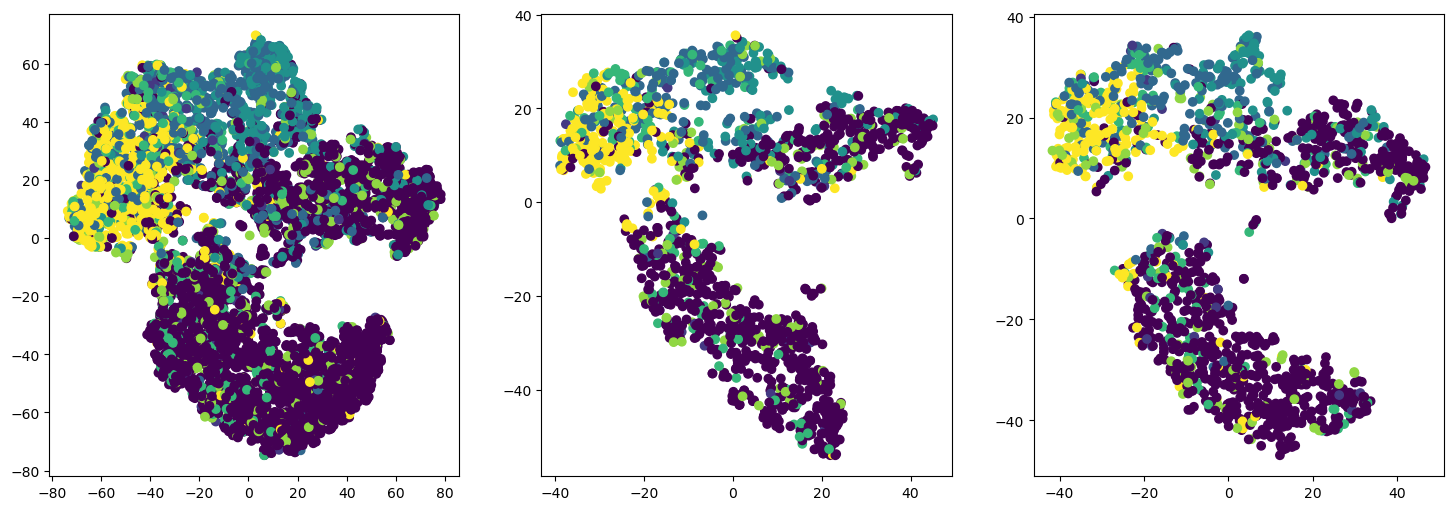

In [26]:
fig = plt.figure(figsize=[18, 6])
tsne_embeddings = TSNE(random_state=42).fit_transform(train_embeddings)
ax = fig.add_subplot(1, 3, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_Y.flatten());

tsne_embeddings = TSNE(random_state=42).fit_transform(test_embeddings)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_Y.flatten());

tsne_embeddings = TSNE(random_state=42).fit_transform(val_embeddings)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = val_Y.flatten());

In [27]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax, xticks_rotation='vertical')
    pred = model.predict(X_train)
    #conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    conf.ax_.set_title('SVM with Triplet loss, Train F1 Score: %f' % f1_score(Y_train, pred, average='weighted'));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax, xticks_rotation='vertical')
    pred = model.predict(X_test)
    #conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));
    conf.ax_.set_title('SVM with Triplet loss, Test F1 Score: %f' % f1_score(Y_test, pred, average='weighted'));

In [28]:
# rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced')#no of trees and depth of trees,, 
# rf.fit(train_embeddings, train_Y)
# eval_model(rf, train_embeddings, train_Y, test_embeddings, test_Y)
# eval_model(rf, train_embeddings, train_Y, val_embeddings, val_Y)

In [29]:
svm = SVC(C=10,kernel="linear",class_weight = 'balanced',random_state=41)

SVM_train_start = process_time()

svm.fit(train_embeddings, train_Y)

SVM_train_end = process_time()
SVM_train_time = SVM_train_end - SVM_train_start
print("SVM_train_time: ", SVM_train_time)

SVM_train_time:  250.5948924669999


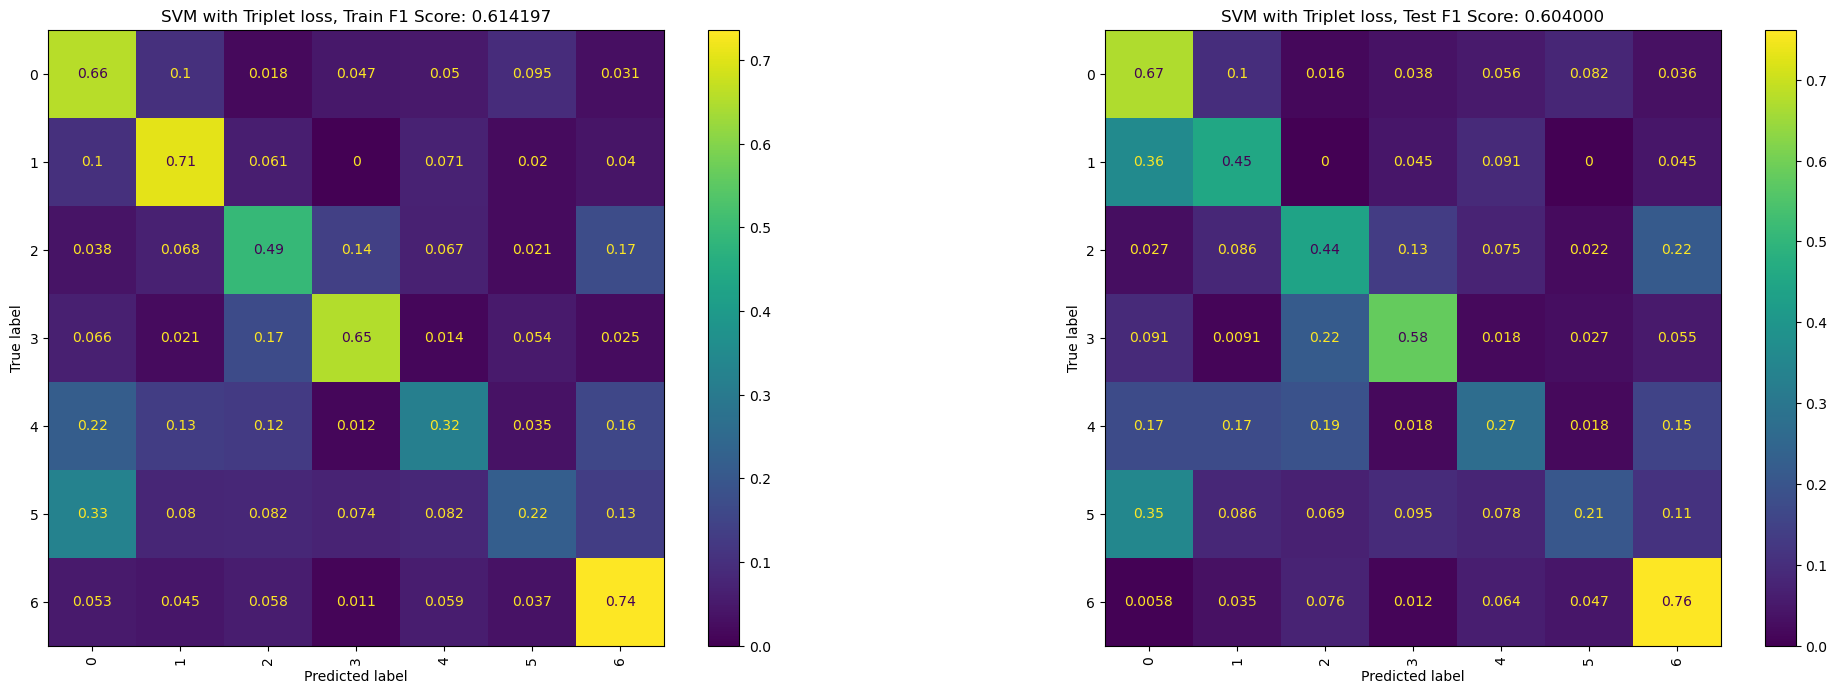

In [30]:

eval_model(svm, train_embeddings, train_Y, test_embeddings, test_Y)

In [31]:
SVM_inference_start = process_time()

print(classification_report(test_Y, svm.predict(test_embeddings)))

SVM_inference_end = process_time()
SVM_inference_time = SVM_inference_end - SVM_inference_start
print("SVM_inference_time: ", SVM_inference_time)

              precision    recall  f1-score   support

           0       0.86      0.67      0.76       788
           1       0.07      0.45      0.12        22
           2       0.51      0.44      0.47       186
           3       0.47      0.58      0.52       110
           4       0.27      0.27      0.27       110
           5       0.23      0.21      0.22       116
           6       0.56      0.76      0.64       172

    accuracy                           0.58      1504
   macro avg       0.42      0.48      0.43      1504
weighted avg       0.65      0.58      0.60      1504

SVM_inference_time:  0.2278127399999903
